In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2.16.2
1 Physical GPUs, 1 Logical GPUs


In [ ]:
import csv

allLabelDict = {}

labelSet = set()
with open("./dev_data_2025.csv", "r") as f:
	csvItems = list(csv.DictReader(f))
	for imgLabel in csvItems:
		labelSet.add(imgLabel['label'])
	
	labelTuple = tuple(labelSet)
	
	for imgLabel in csvItems:
		allLabelDict[imgLabel['imageID']] = [
			labelTuple.index(imgLabel['label']), 
			imgLabel['cell_shape'], 
			imgLabel['nucleus_shape'], 
			imgLabel['cytoplasm_vacuole']
		]

print(labelSet)
print(allLabelDict['Img_00005'])

{'Monocyte', 'Neutrophil', 'Eosinophil', 'Basophil', 'Lymphocyte'}
[1, 'round', 'unsegmented-band', 'no']


In [92]:
def getLabel(path):
	path = path.numpy().decode("utf-8")
	key = os.path.basename(path)[:9]
	
	if key not in allLabelDict:
		print("Missing key:", key)
		raise ValueError("Missing label key.")
	return allLabelDict[key]

def getImage(path):
	img = tf.io.read_file(path)
	img = tf.io.decode_jpeg(img, channels=3)
	return tf.image.resize_with_crop_or_pad(img, 360, 360)

def process_path(file_path):    
	label = tf.py_function(func=getLabel, inp=[file_path], Tout=tf.uint32)
	label.set_shape([])

	img = tf.py_function(func=getImage, inp=[file_path], Tout=tf.uint8)
	img.set_shape([None, None, 3])

	return img, label


valSize = int(imageFileNames.cardinality().numpy() * 0.2)

trainData = imageFileNames \
  .skip(valSize) \
  .map(process_path, num_parallel_calls=tf.data.AUTOTUNE) \
  .cache() \
  .batch(100) \
  .prefetch(buffer_size=tf.data.AUTOTUNE)
valData = imageFileNames \
  .take(valSize) \
  .map(process_path, num_parallel_calls=tf.data.AUTOTUNE) \
  .cache() \
  .batch(100) \
  .prefetch(buffer_size=tf.data.AUTOTUNE)

print(tf.data.experimental.cardinality(trainData).numpy())
print(tf.data.experimental.cardinality(valData).numpy())

for image, label in trainData.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())


40
10
Image shape:  (100, 360, 360, 3)
Label:  [1 3 1 4 3 2 2 1 1 1 1 3 2 2 3 3 1 1 4 1 4 1 2 1 1 1 0 0 1 1 0 4 2 3 0 3 4
 0 2 0 1 4 4 2 2 2 3 2 2 2 2 3 2 1 2 0 0 2 4 1 2 1 2 0 2 1 1 1 2 2 2 0 1 1
 1 1 3 2 1 2 1 2 0 1 1 1 2 0 2 1 1 3 1 1 2 1 3 2 1 2]


2025-08-14 00:12:54.193475: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2025-08-14 00:12:57.955565: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


TypeError: Invalid shape (100, 360, 360, 3) for image data

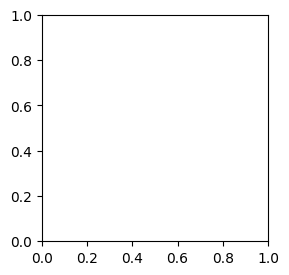

In [93]:
# Visuals
plt.figure(figsize=(10, 10))
i = 0
for image, label in trainData.take(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image.numpy().astype("uint8"))
  plt.title(str(label.numpy()))
  plt.axis("off")
  i += 1


In [96]:
num_classes = len(labelSet)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(360, 360, 3)),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(num_classes)  
])

model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()


/home/archfishgame/deep/deep-learning/.venv/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ (None, 360, 360, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 358, 358, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 179, 179, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 177, 177, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 88, 88, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 86, 86, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 59168)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │     1,893,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,914,021 (7.30 MB)

 Trainable params: 1,914,021 (7.30 MB)

 Non-trainable params: 0 (0.00 B)

In [97]:
history = model.fit(
  trainData,
  validation_data=valData,
  epochs=3,
	validation_steps=1
)


Epoch 1/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.3485 - loss: 1.4875 - val_accuracy: 0.4900 - val_loss: 1.2097
Epoch 2/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - accuracy: 0.5680 - loss: 1.0393 - val_accuracy: 0.6600 - val_loss: 0.8742
Epoch 3/3


2025-08-14 00:14:49.092197: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.6902 - loss: 0.8055 - val_accuracy: 0.7100 - val_loss: 0.7549


2025-08-14 00:14:56.874720: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-08-14 00:14:57.059310: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


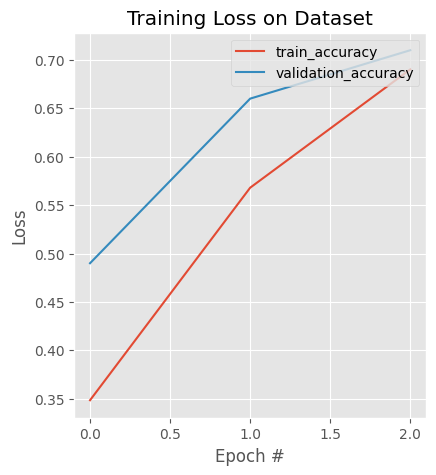

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
test accuracy: $[ 0.8182536 -4.1110735 -2.8892348 -1.2795702 -9.311018 ]


In [106]:
plt.style.use("ggplot")
plt.figure(figsize=(10,5))
Nepoch=3
plt.subplot(1,2,1)
plt.plot(np.arange(0, Nepoch), history.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, Nepoch), history.history["val_accuracy"], label="validation_accuracy")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

print(f'test accuracy: ${model.predict(valData)[1]}')